# Implement a custom Autoencoder with Koopman layer

This code is to load a model (only)

## Version Control

To Do:
1) Account for trailing batch - Make robust (fixed issue by reshaping input data)
2) Preprocess Data
3) Make sure sim data is different for different ground parameters
4) Validation data has different batch size. Address when HP training
5) Address semi graident issue for K^m*z in linearity loss (Prob fine)

## Setup

In [1]:
import tensorflow as tf
import matplotlib as mpl
from matplotlib import pyplot as plt
from tensorflow import keras

import  numpy as np
import pandas as pd

import matplotlib.colors as mcol

import time 
import os

import glob

In [2]:
plt.rcParams['figure.figsize'] = [9, 6]
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
#from google.colab import drive
#drive.mount('/gdrive')

Comment out if don't need

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


1 Physical GPUs, 1 Logical GPUs


# Load the Model

In [6]:
new_model = tf.keras.models.load_model('checkpoints/champ_Trained_Model', compile=False)
new_model.summary()

Model: "Koopman_AE_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_model (EncoderModel) multiple                  5376      
_________________________________________________________________
koopman__model (Koopman_Mode multiple                  256       
_________________________________________________________________
decoder_model (DecoderModel) multiple                  5366      
Total params: 10,998
Trainable params: 10,998
Non-trainable params: 0
_________________________________________________________________


## Load data

### Read Sim Data Functions

In [16]:
def preprocessSimData(df, desiredStates:list, initialIndex:int=300, finalIndex:int=812):
    '''
    Preprocess text file (fixing formatting issue in data as well) while returning a dataframe object with the desired states selected

    Parameters:
    -----------
    df: dataFrame
        Panda dataframe that is read from one of the recorded simulation .txt files
    desiredStates: list
        List of desired states to return as a panda dataframe object in sequential order

    Return:
    ----------
    stateMatrix: dataFrame
        State matrix with desired states
    '''



    # Fix formatting Variables
    falseList = ['time_lf_hip_joint_position', 'lf_lower_leg_joint_position', 'lf_upper_leg_joint_position', 'lh_hip_joint_position', 'lh_lower_leg_joint_position', 'lh_upper_leg_joint_position',
                'rf_hip_joint_position', 'rf_lower_leg_joint_position', 'rf_upper_leg_joint_position', 'rh_hip_joint_position', 'rh_lower_leg_joint_position', 'rh_upper_leg_joint_position',
                'lf_hip_joint_vel', 'lf_lower_leg_joint_vel', 'lf_upper_leg_joint_vel', 'lh_hip_joint_vel', 'lh_lower_leg_joint_vel', 'lh_upper_leg_joint_vel',
                'rf_hip_joint_vel', 'rf_lower_leg_joint_vel', 'rf_upper_leg_joint_vel', 'rh_hip_joint_vel', 'rh_lower_leg_joint_vel', 'rh_upper_leg_joint_vel',
                'lf_hip_joint_effort', 'lf_lower_leg_joint_effort', 'lf_upper_leg_joint_effort', 'lh_hip_joint_effort', 'lh_lower_leg_joint_effort', 'lh_upper_leg_joint_effort',
                'rf_hip_joint_effort', 'rf_lower_leg_joint_effort', 'rf_upper_leg_joint_effort', 'rh_hip_joint_effort', 'rh_lower_leg_joint_effort', 'rh_upper_leg_joint_effort', 'nan']
    df.columns = falseList
    df['time_lf_hip_joint_position'] = df.time_lf_hip_joint_position.str[0:8] + ' ' + df.time_lf_hip_joint_position.str[8:]


    # Data and State Name List
    data = df.values # np array of data values
    namesList = ['time', 'lf_hip_joint_position', 'lf_lower_leg_joint_position', 'lf_upper_leg_joint_position', 'lh_hip_joint_position', 'lh_lower_leg_joint_position', 'lh_upper_leg_joint_position',
                'rf_hip_joint_position', 'rf_lower_leg_joint_position', 'rf_upper_leg_joint_position', 'rh_hip_joint_position', 'rh_lower_leg_joint_position', 'rh_upper_leg_joint_position',
                'lf_hip_joint_vel', 'lf_lower_leg_joint_vel', 'lf_upper_leg_joint_vel', 'lh_hip_joint_vel', 'lh_lower_leg_joint_vel', 'lh_upper_leg_joint_vel',
                'rf_hip_joint_vel', 'rf_lower_leg_joint_vel', 'rf_upper_leg_joint_vel', 'rh_hip_joint_vel', 'rh_lower_leg_joint_vel', 'rh_upper_leg_joint_vel',
                'lf_hip_joint_effort', 'lf_lower_leg_joint_effort', 'lf_upper_leg_joint_effort', 'lh_hip_joint_effort', 'lh_lower_leg_joint_effort', 'lh_upper_leg_joint_effort',
                'rf_hip_joint_effort', 'rf_lower_leg_joint_effort', 'rf_upper_leg_joint_effort', 'rh_hip_joint_effort', 'rh_lower_leg_joint_effort', 'rh_upper_leg_joint_effort']

    dictStates = {}
    staticCounter = 0 # Variable to account for formatting issue
    for index in range(len(namesList)-1):
        if index == 0 and staticCounter == 0: # Condition for formatting issue of collected data
            for j in range(len(data[:,index])): # Looping through all elements in column 0 and converting to float
                if j == 0: # Initialize array
                    array1 = float(data[j,index][0:8])
                    #print(array1)
                    array2 = float(data[j,index][8:])
                    #print(array2)
                else:
                    array1 = np.vstack((array1,float(data[j,index][0:8])))
                    array2 = np.vstack((array2,float(data[j,index][8:])))
            dictStates[namesList[index]] = np.squeeze(array1[initialIndex:finalIndex])
            dictStates[namesList[index+1]] = np.squeeze(array2[initialIndex:finalIndex])        
        else:
            dictStates[namesList[index+1]] = data[initialIndex:finalIndex,index]
    for counter, names in enumerate(desiredStates):
        if counter == 0:
            stateMatrix = np.reshape(dictStates[names], (-1,1))
        else:
            stateMatrix = np.hstack((stateMatrix, np.reshape(dictStates[names], (-1,1))))
    return pd.DataFrame(stateMatrix, columns = desiredStates)



def preprocessFile(fileNames:list, initialIndex:int, finalIndex:int, desiredStates:list):
    '''
    Given fileNames to read, reads the file(s) and returns all data concatenated in a panda dataframe framework

    Paramaters:
    -----------
    fileNamess:list
        List of filenames to read and concatenate data together
    intialIndex: int
        Index to start reading each file's data from
    finalIndex: int
        Index to stop reading each file's data from
    desiredStates:list
        List of states to read
    
    Return:
    ----------
    totalData: dataFrame
        Returns data of all filenames with given states in one panda dataframe
    '''

    filePaths = []
    for i in fileNames:
        filePaths.append(glob.glob(i))
    #print(filePaths)


    dataFrameList = []
    for i in filePaths:
        for j in i:
            df = pd.read_csv(j, sep= " ", header=None)
            dataFrameList.append(preprocessSimData(df, desiredStates, initialIndex=initialIndex, finalIndex=finalIndex)) # 712-200 = 512 --> 512-1 is 512 indices (i.e. [0, 511])

    totalData = pd.concat(dataFrameList)
    return totalData

### Read full data

In [17]:
# List of states
namesList = ['time', 'lf_hip_joint_position', 'lf_lower_leg_joint_position', 'lf_upper_leg_joint_position', 'lh_hip_joint_position', 'lh_lower_leg_joint_position', 'lh_upper_leg_joint_position',
                'rf_hip_joint_position', 'rf_lower_leg_joint_position', 'rf_upper_leg_joint_position', 'rh_hip_joint_position', 'rh_lower_leg_joint_position', 'rh_upper_leg_joint_position',
                'lf_hip_joint_vel', 'lf_lower_leg_joint_vel', 'lf_upper_leg_joint_vel', 'lh_hip_joint_vel', 'lh_lower_leg_joint_vel', 'lh_upper_leg_joint_vel',
                'rf_hip_joint_vel', 'rf_lower_leg_joint_vel', 'rf_upper_leg_joint_vel', 'rh_hip_joint_vel', 'rh_lower_leg_joint_vel', 'rh_upper_leg_joint_vel',
                'lf_hip_joint_effort', 'lf_lower_leg_joint_effort', 'lf_upper_leg_joint_effort', 'lh_hip_joint_effort', 'lh_lower_leg_joint_effort', 'lh_upper_leg_joint_effort',
                'rf_hip_joint_effort', 'rf_lower_leg_joint_effort', 'rf_upper_leg_joint_effort', 'rh_hip_joint_effort', 'rh_lower_leg_joint_effort', 'rh_upper_leg_joint_effort']


In [18]:
desiredStates = ['lf_hip_joint_position', 'lf_hip_joint_vel', 'lf_upper_leg_joint_position', 'lf_upper_leg_joint_vel', 'lf_hip_joint_effort', 'lf_upper_leg_joint_effort']

input_dim = len(desiredStates)
output_dim = input_dim

trajLength = 2**7 # Length of each trajectory in the dataset

filePath = "simData"
fileNames = [filePath + '/plane_kp_100e10_kd_0/joint_state_test_plane_kp_100e10_kd_0_forward_0.1*']


numTraj = 4 # Total number of trajectories in the dataset (train)
numTraj_val = 1
batch_size = int(2**7) # Number of snapshots in each batch
numTraj_batch = int(batch_size/trajLength)


initialIndex, finalIndex= 200, 200+trajLength*(numTraj+numTraj_val)

num_batches_train = int(trajLength*numTraj/batch_size) ## num_batches = trajLength*numTraj/batch_size 
num_batches_val = int(trajLength*numTraj_val/batch_size)


In [19]:
doggoFrame = preprocessFile(fileNames,initialIndex,finalIndex, desiredStates)
doggoFrame.head(5)

,lf_hip_joint_position,lf_hip_joint_vel,lf_upper_leg_joint_position,lf_upper_leg_joint_vel,lf_hip_joint_effort,lf_upper_leg_joint_effort
0,-0.0005,0.0852,0.7882,-1.9969,0.107,0.0
1,-0.0004,0.0631,0.7783,-2.1027,0.0889,0.0
2,-0.0004,0.0054,0.7678,-2.1415,0.086,0.0
3,-0.0004,0.0151,0.7566,-2.3025,0.0593,0.0214
4,-0.0003,0.0099,0.7449,-2.402,0.0539,0.0303


In [20]:
print("Datapoints: ", len(doggoFrame.index))

Datapoints:  640


In [21]:
doggo_train = doggoFrame.values[:numTraj*trajLength,:]
doggo_validation = doggoFrame.values[numTraj*trajLength:(numTraj+numTraj_val)*trajLength,:]
doggo_test = doggoFrame.values[(numTraj+numTraj_val)*trajLength:,:]

doggo_train = np.asarray(doggo_train).astype('float32')
doggo_test = np.asarray(doggo_test).astype('float32')
doggo_validation = np.asarray(doggo_validation).astype('float32')

In [22]:
print("Size of doggo_train:", len(doggo_train))
print("Size of doggo_validation:", len(doggo_validation))
print("Size of doggo_test:", len(doggo_test))

Size of doggo_train: 512
Size of doggo_validation: 128
Size of doggo_test: 0


### Make into dataset

In [23]:
# Normalize the data
min_val = tf.reduce_min(doggo_train)
max_val = tf.reduce_max(doggo_train)

doggo_train = (doggo_train - min_val) / (max_val - min_val)
doggo_validation = (doggo_validation - min_val) / (max_val - min_val)
doggo_test = (doggo_test - min_val) / (max_val - min_val)

train_data = tf.cast(doggo_train[0:batch_size*num_batches_train], tf.float32)
validation_data = tf.cast(doggo_validation[0:batch_size*num_batches_val], tf.float32)
validation_data = tf.data.Dataset.from_tensor_slices((validation_data, validation_data)).batch(batch_size)
test_data = tf.cast(doggo_test, tf.float32)

In [24]:
x_train = train_data
y_train = train_data

# Load data into model

In [25]:
input = x_train
new_out1, new_out2, new_out3 = new_model(input)

### Graphing Error Section

#### Average Error Function

In [26]:
def preProcessForAvg(input, numTraj_batch, trajLength, desiredStates, model):
    '''
    Given input, the number of trajectory in each batch, and the trajector length, outputs
    batch data concatenated vertically on top of one another by calling the Koopman AE class

    Parameters:
    -----------
    input: Tensor
        Input data to reshape into outputs
    numTraj_batch: int
        Number of trajectory per batch
    trajLength: int
        Number of snapshots in a trajectory
    desiredStates: list
        List of states
    model: Koopman AE keras model
        Koopman AE model to propagate data

    Return:
    ----------
    x1_all: tensor
        Copy of input (No need for change) (Ground Truth)
    x2_all: tensor
        Concatenated tensor of 1 time shifted data for all batches (Ground Truth)
    x3_all: tensor
        Concatenated tensor of 1 time step shifted data for all batches (x2_all=x3_all) (Ground Truth)
    out1_all: tensor
        Reconstruction of input (parameter) using the Koopman AE class
    out2_all: tensor
        Predicted output from Koopman model of concatenated tensors of 1 time shifted data for all batches
    out3_all: tensor
        Predicted n time step output from Koopman model of concatenated tensors data for all batches
    '''
    
    x2_all = []
    out1_all = []
    out2_all = []
    out3_all = []
    x = input
    #print("Input shape", tf.shape(x))
    for i in range(numTraj):
        x2 = []
        for j in range(numTraj_batch):
            x2.append(x[(i*numTraj_batch+j)*trajLength+1:(i*numTraj_batch+j+1)*trajLength])
        x2 = tf.reshape(x2, [-1, x.shape[-1]]) # Shifted input for a batch
        x2_all.append(x2)
        
        x_input = x[i*numTraj_batch*trajLength:(i*numTraj_batch+1)*trajLength]
        out1, out2, out3 = model(x_input)
        out1_all.append(out1)
        out2_all.append(out2)
        out3_all.append(out3)
        
    x1_all = x
    x2_all = tf.reshape(x2_all,(-1,len(desiredStates)))
    x3_all = x2_all
    out1_all = tf.reshape(out1_all,(-1,len(desiredStates)))
    out2_all = tf.reshape(out2_all,(-1,len(desiredStates)))
    out3_all = tf.reshape(out3_all,(-1,len(desiredStates)))

    '''
    print(tf.shape(x2_all))
    print(tf.shape(out1_all))
    print(tf.shape(out2_all))
    print(tf.shape(out3_all))
    '''

    return x1_all, x2_all, x3_all, out1_all, out2_all, out3_all

In [39]:
def avgTrajError(gTruth, predicted, trajLength, numTraj):
    '''
    Get the average trajectory error with min and max values (Maybe std dev better)

    Parameters:
    -----------
    gTruth: tensor or ndarray
        Ground Truth matrix
    predicted: tensor or ndarray
        Predicted matrix
    trajLength: int
        Length of trajectory
    numTraj: int
        Number of trajectory (total?)
    

    Return:
    ----------
    avgErrorList: list
        List of average errors of all trajectories (each index is the avg error of the states at a point of time along the trajectory)
    
    errorList: list
        List of error of all states and trajectory
    '''
    errorList = []
    avgErrorList = []
    numStates = len(gTruth[0,:])
    for i in range(numTraj):
        '''
        print("Gtruth")
        print(np.array(gTruth)[i*trajLength:(i+1)*trajLength,:])
        print("Predicted")
        print(np.array(predicted[i*trajLength:(i+1)*trajLength,:]))
        print("---Loop---")
        '''
        errorList.append(np.array(gTruth)[i*trajLength:(i+1)*trajLength,:] - np.array(predicted[i*trajLength:(i+1)*trajLength,:]))
    
    #print("Error List")
    #print(np.shape(errorList[0]))
    
    for j in range(trajLength):
        #print("Length of Traj %d"% j)
        for k in range(numTraj):
            #print("Traj: %d"% k)
            if k == 0:
                avgErrorList.append(errorList[k][j,:])
            else:
                #print(avgErrorList[j])
                avgErrorList[j] = (k*avgErrorList[j]+errorList[k][j,:])/(k+1) # Recursive average formula
    return avgErrorList, errorList
        
    

In [40]:
'''
testVar = np.array([[1,2,3],[2,3,4],[3,4,5],[4,5,6]])
testVar2 = np.array([[2,3,4],[3,4,5],[4,5,6],[6,7,8]])
print(np.shape(testVar))
avgTrajError(testVar2, testVar,2,2)
'''

'\ntestVar = np.array([[1,2,3],[2,3,4],[3,4,5],[4,5,6]])\ntestVar2 = np.array([[2,3,4],[3,4,5],[4,5,6],[6,7,8]])\nprint(np.shape(testVar))\navgTrajError(testVar2, testVar,2,2)\n'

#### Preprocess Error Graph Data

In [41]:
x1_all,x2_all,x3_all, out1_all,out2_all,out3_all = preProcessForAvg(x_train,numTraj_batch, trajLength, desiredStates, model=new_model)
avgTrajErrorList, errorList = avgTrajError(x3_all, out3_all, trajLength-1, numTraj)

In [42]:
saveErrorPath = 'errorGraph/'
try:
    os.mkdir(saveErrorPath)
except OSError as exc:
    print(exc.errno)

17


#### Error Graphs

##### Reconstruction Error

In [43]:
avgTrajErrorList, errorList = avgTrajError(x1_all, out1_all, trajLength, numTraj)
avgTrajErrorArray = np.array(avgTrajErrorList)
errorArray = np.array(errorList)
errorStdDevArray = np.std(errorArray,axis=0)

In [44]:
for i in range(len(desiredStates)):
    plt.figure()
    plt.style.use('default')
    plt.plot(avgTrajErrorArray[:,i])
    plt.fill_between(range(len(errorStdDevArray[:,i])), avgTrajErrorArray[:,i]-errorStdDevArray[:,i], avgTrajErrorArray[:,i]+errorStdDevArray[:,i],alpha = 0.3)
    title=desiredStates[i]
    plt.title(title)
    plt.ylabel("Reconstruction Error")
    plt.xlabel("Time Step")
    plt.ylim((0,1))
    plt.savefig(saveErrorPath+'recon_'+title+'.png', dpi=300)
    plt.close()

##### Forward Time Shift Prediction Error

In [45]:
avgTrajErrorList, errorList = avgTrajError(x2_all, out2_all, trajLength-1, numTraj)
avgTrajErrorArray = np.array(avgTrajErrorList)
errorArray = np.array(errorList)
errorStdDevArray = np.std(errorArray,axis=0)

In [46]:
for i in range(len(desiredStates)):
    plt.figure()
    plt.style.use('default')
    plt.plot(avgTrajErrorArray[:,i])
    plt.fill_between(range(len(errorStdDevArray[:,i])), avgTrajErrorArray[:,i]-errorStdDevArray[:,i], avgTrajErrorArray[:,i]+errorStdDevArray[:,i],alpha = 0.3)
    title=desiredStates[i]
    plt.title(title)
    plt.ylabel("Forward Time Shift Prediction Error")
    plt.xlabel("Time Step")
    plt.ylim((0,1))
    plt.savefig(saveErrorPath+'ftimeShift_'+title+'.png', dpi=300)
    plt.close()

##### Linearity Prediction Error

In [47]:
avgTrajErrorList, errorList = avgTrajError(x3_all, out3_all, trajLength-1, numTraj)
avgTrajErrorArray = np.array(avgTrajErrorList)
errorArray = np.array(errorList)
errorStdDevArray = np.std(errorArray,axis=0)

In [48]:
for i in range(len(desiredStates)):
    plt.figure()
    plt.style.use('default')
    plt.plot(avgTrajErrorArray[:,i])
    plt.fill_between(range(len(errorStdDevArray[:,i])), avgTrajErrorArray[:,i]-errorStdDevArray[:,i], avgTrajErrorArray[:,i]+errorStdDevArray[:,i],alpha = 0.3)
    title=desiredStates[i]
    plt.title(title)
    plt.ylabel("Linear Prediction Error")
    plt.xlabel("Time Step")
    plt.ylim((0,1))
    plt.savefig(saveErrorPath+'linPred_'+title+'.png', dpi=300)
    plt.close()

##### Miscellaneous

NameError: name 'x2' is not defined

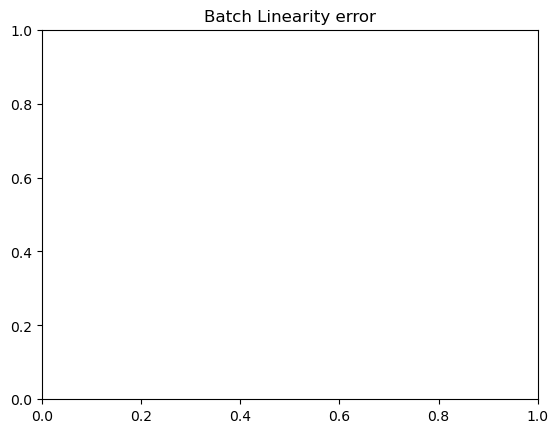

In [49]:
plt.title("Batch Linearity error")
plt.rcParams['figure.figsize'] = [5, 3]
plt.plot((tf.square(tf.subtract(x2[:,5],out3[:,5]))), label = "Linearity Error")
plt.legend()

In [ ]:
x = input
x2 = []
for i in range(numTraj_batch):
    x2.append(x[i*trajLength+1:(i+1)*trajLength])
x2 = tf.reshape(x2, [-1, x.shape[-1]]) # Shifted input

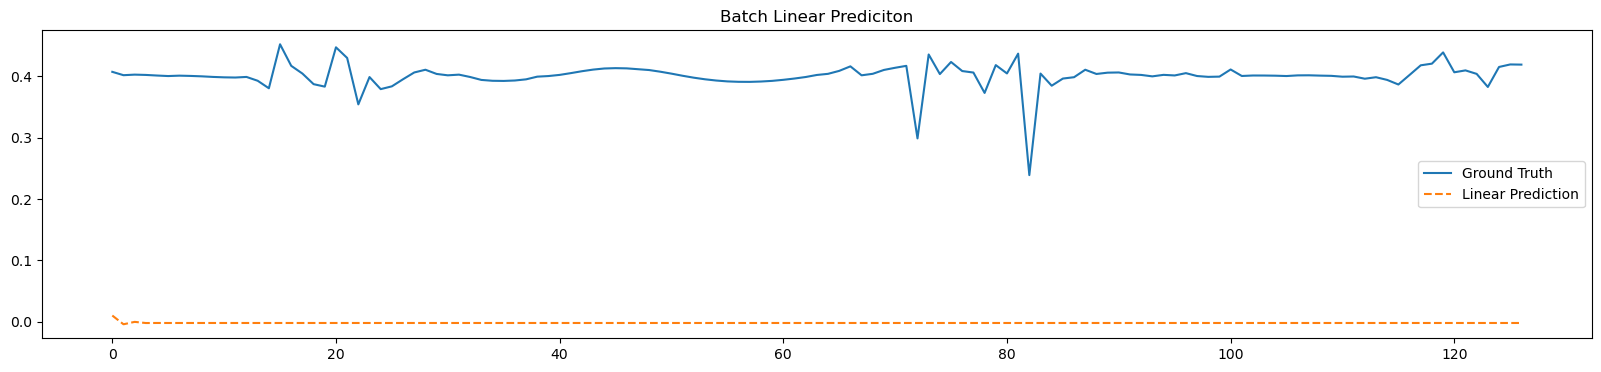

In [ ]:
plt.figure(figsize=(20,4))
plt.title("Batch Linear Prediciton")
plt.rcParams['figure.figsize'] = [9, 6]
plt.plot(x2[0:,1], label = "Ground Truth")
plt.plot(out3[0:,1], '--', label="Linear Prediction")
plt.legend()

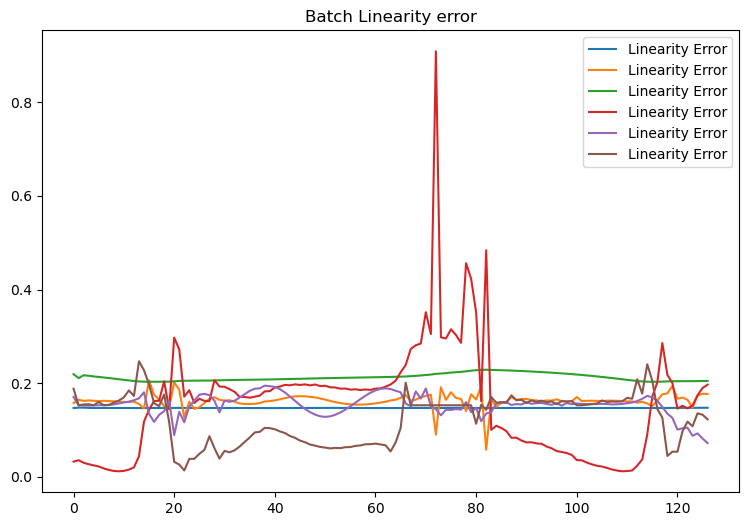

In [ ]:
plt.title("Batch Linearity error")
plt.rcParams['figure.figsize'] = [9, 6]
plt.plot((tf.square(tf.subtract(x2,out3))), label = "Linearity Error")
plt.legend()

# Plots on Test Data

In [ ]:
input = test_data
new_out1, new_out2, new_out3 = new_model(input)


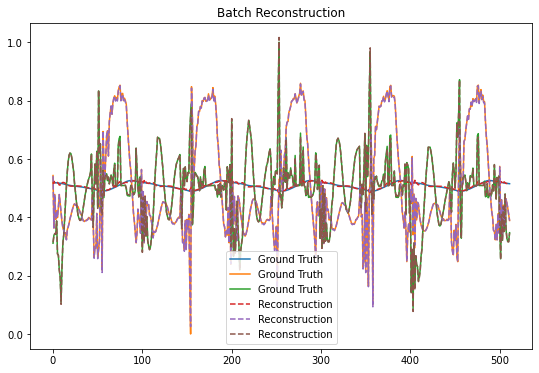

In [ ]:
plt.title("Batch Reconstruction")
plt.rcParams['figure.figsize'] = [9, 6]
plt.plot(input, label = "Ground Truth")
plt.plot(new_out1, '--', label="Reconstruction")
plt.legend()

In [ ]:
x = input
x2 = []
for i in range(numTraj_batch):
    x2.append(x[i*trajLength+1:(i+1)*trajLength])
x2 = tf.reshape(x2, [-1, x.shape[-1]]) # Shifted input

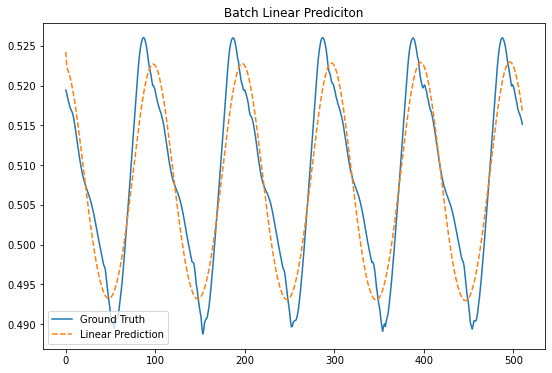

In [ ]:
plt.title("Batch Linear Prediciton")
plt.rcParams['figure.figsize'] = [9, 6]
plt.plot(x2[:,0], label = "Ground Truth")
plt.plot(new_out3[:,0], '--', label="Linear Prediction")
plt.legend()